In [1]:
import pandas as pd
import matplotlib.pyplot as plt


C:\Users\Eduardo\AppData\Local\Temp\ipykernel_36124\2471262982.py:7: DtypeWarning: Columns (6,16,20,31,33,36,39,40,41,43,46,52,53,55,57,58,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  stations_data = pd.read_csv('Electric and Alternative Fuel Charging Stations.csv')
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_36124\2471262982.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_2010_data[state + '_stations_per_vehicle'] = pre_2010_data[station_col] / pre_2010_data[vehicle_col]
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_36124\2471262982.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

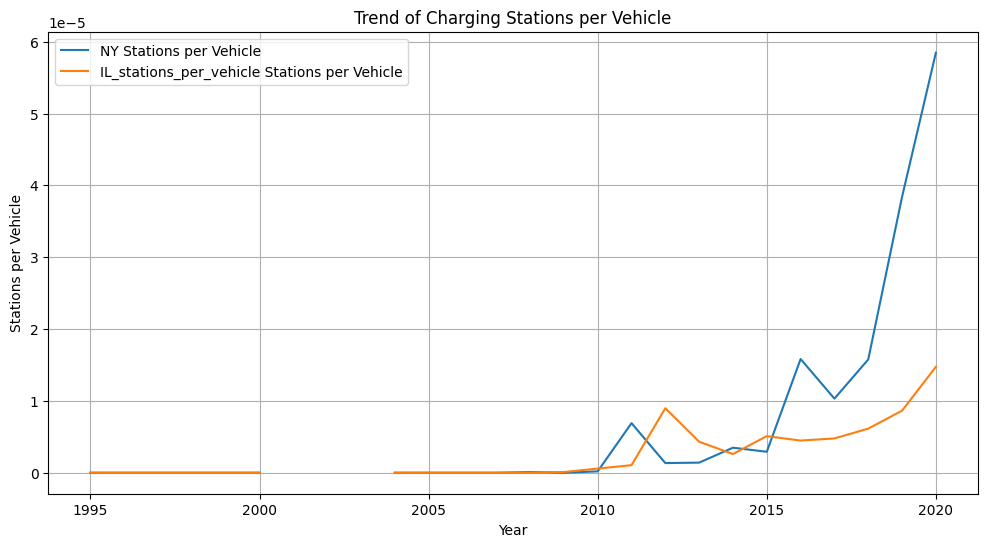

In [2]:
# Código para preparar las bases de datos para su fusión

# Base de vehículos totales por estado
vehicles_data = pd.read_csv('vehicles_total_state-to2020.csv')

# Base de estaciones de carga
stations_data = pd.read_csv('Electric and Alternative Fuel Charging Stations.csv')

# Preparando los datos de estaciones de carga
stations_data['Open Date'] = pd.to_datetime(stations_data['Open Date'], errors='coerce')
stations_data['year'] = stations_data['Open Date'].dt.year
elec_charging_stations = stations_data[stations_data['Fuel Type Code'] == 'ELEC']
elec_stations_by_state_year = elec_charging_stations.groupby(['year', 'State']).size().unstack(fill_value=0)

# Preparando los datos de vehículos totales por estado
vehicles_data_pivot = vehicles_data.pivot(index='year', columns='state', values='Total_Vehicles')

# Combinando los conjuntos de datos
combined_data = elec_stations_by_state_year.join(vehicles_data_pivot, how='outer', lsuffix='_stations', rsuffix='_vehicles')

# Filtrando datos para el período pre-2010 y calculando proporciones
pre_2010_data = combined_data[combined_data.index < 2010]
for state in elec_stations_by_state_year.columns:
    station_col = state + '_stations'
    vehicle_col = state + '_vehicles'
    if station_col in pre_2010_data.columns and vehicle_col in pre_2010_data.columns:
        pre_2010_data[state + '_stations_per_vehicle'] = pre_2010_data[station_col] / pre_2010_data[vehicle_col]

# Calculando medias y encontrando el estado más similar a Nueva York
mean_stations_per_vehicle_pre_2010 = pre_2010_data.filter(like='_stations_per_vehicle').mean()
ny_mean_pre_2010 = mean_stations_per_vehicle_pre_2010['NY_stations_per_vehicle']
state_most_similar_to_ny = mean_stations_per_vehicle_pre_2010.sub(ny_mean_pre_2010).abs().sort_values().index[1]

# Código para graficar la tendencia de estaciones de carga por vehículo para NY y el estado similar
import matplotlib.pyplot as plt

# Calculando proporciones para NY y el estado similar para todo el período
combined_data['NY_stations_per_vehicle'] = combined_data['NY_stations'] / combined_data['NY_vehicles']
combined_data[state_most_similar_to_ny] = combined_data[state_most_similar_to_ny.replace('_stations_per_vehicle', '_stations')] / combined_data[state_most_similar_to_ny.replace('_stations_per_vehicle', '_vehicles')]

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['NY_stations_per_vehicle'], label='NY Stations per Vehicle')
plt.plot(combined_data.index, combined_data[state_most_similar_to_ny], label=f'{state_most_similar_to_ny} Stations per Vehicle')
plt.title('Trend of Charging Stations per Vehicle')
plt.xlabel('Year')
plt.ylabel('Stations per Vehicle')
plt.legend()
plt.grid(True)
plt.show()